In [1]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from dataset import ThyroidNodules
from torch.utils.data import DataLoader
from glob import glob
from trainer import Trainer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    jaccard_score,
    precision_score,
    recall_score,
)
from eval import compute_loss,DiceLoss,calculate_metrics
from timeit import default_timer as timer
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.utils import weight_norm
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
%load_ext autoreload
%autoreload 2

/Users/eloise-em/miniconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/eloise-em/miniconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <5AA8DD3D-A2CC-31CA-8060-88B4E9C18B09> /Users/eloise-em/miniconda3/envs/tensorflow/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <DA0809A3-4EF8-39B3-82E0-50F09210AA3E> /Users/eloise-em/miniconda3/envs/tensorflow/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# # Batch size and image dimensions
# BATCH_SIZE = 16
# HEIGHT = 128
# WIDTH = 128

# # Hyperparameters
# H = HEIGHT
# W = WIDTH
# DEFAULT_LR = 0.001

# train_x= sorted(glob(os.path.join("/Users/eloise-em/Documents/Haris Ghafoor Archive/Research and Development/RnD/Thyroid Dataset/tn3k/trainval-image",'*')))
# train_y= sorted(glob(os.path.join("/Users/eloise-em/Documents/Haris Ghafoor Archive/Research and Development/RnD/Thyroid Dataset/tn3k/trainval-mask",'*')))

# valid_x= sorted(glob(os.path.join("/Users/eloise-em/Documents/Haris Ghafoor Archive/Research and Development/RnD/Thyroid Dataset/tn3k/test-image",'*')))
# valid_y= sorted(glob(os.path.join("/Users/eloise-em/Documents/Haris Ghafoor Archive/Research and Development/RnD/Thyroid Dataset/tn3k/test-mask",'*')))

# # valid_x = "/Users/eloise-em/Documents/Haris Ghafoor Archive/Research and Development/RnD/Thyroid Dataset/tn3k/test-image"
# # valid_y = "/Users/eloise-em/Documents/Haris Ghafoor Archive/Research and Development/RnD/Thyroid Dataset/tn3k/test-mask"
# # Create datasets and dataloaders for this fold
# train_dataset = ThyroidNodules(
#     train_x,
#     train_y,
#     image_size=(H, W),
# )

# valid_dataset = ThyroidNodules(
#     valid_x,
#     valid_y,
#     image_size=(H, W),
# )

# train_loader = DataLoader(
#     dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
# )
# valid_loader = DataLoader(
#     dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
# )
# # device = torch.device(args.device)
# # print("Device:", device)

# # model = AttentionUNetppGradual()
# # model = model.to(device)

# # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
# #     optimizer, "min", patience=10, verbose=True
# # )

In [3]:
trainer = Trainer(seed=7)
input = next(iter(trainer.train_loader))[0].to(trainer.device)
output = trainer.model(input)
target = next(iter(trainer.train_loader))[1].to(trainer.device)
loss = compute_loss(output, target)
print("output", output.shape)
print("target", target.shape)
print("loss", loss)


Using CPU
output torch.Size([32, 1, 256, 256])
target torch.Size([32, 1, 256, 256])
loss tensor(1.8173, grad_fn=<AddBackward0>)


In [4]:
DiceLoss()

DiceLoss()

In [5]:
model = trainer.model
checkpoint = torch.load(
    "./model_best.pth.tar",
    map_location=trainer.device,
)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

Unet(
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  

In [6]:
for m in model.modules():
    for child in m.children():
        if type(child) == nn.BatchNorm2d:
            child.track_running_stats = False

In [7]:
# # dict_results = trainer.predict(model = model)
# # results = {"metrics": []}
# results = np.array([])
# dice_score = 0
# count = []
# for x,y in trainer.test_dataset:
# #   model.train()
#     # optim
#     # print(x.shape,y.shape)
#     with torch.no_grad():
#         images = x.unsqueeze(0).to(trainer.device)
#         labels = y.to(trainer.device).squeeze(0)
#         out = model(images).squeeze(0)
#     out = F.sigmoid(out)
#     dice_loss = DiceLoss()(out, labels)
#     dice_loss = 1 - dice_loss.item()
#     dice_score+= dice_loss
#     # print(images.shape,labels.shape,out.shape)
#     results = calculate_metrics(y_true=labels, y_pred=out, threshold=0.5)
#     results+= np.array(results)
#     # break
# results = results / len(trainer.test_dataset)
# dice_score = dice_score / len(trainer.test_dataset)

In [8]:
# labels.unique()

In [9]:
# results,dice_score,len(trainer.test_dataset)

In [10]:
# print(images.shape,labels.shape,out.shape)

In [11]:
# # dict_results = trainer.predict(model = model)
# # results = {"metrics": []}
# results = np.array([])
# batch_metrics = np.zeros(5)
# dice_loss = 0
# count = []
# batch_dice_score_valid = []
# for x, y in trainer.test_loader:
#     images = x.to(trainer.device)
#     labels = y.to(trainer.device)
#     out = model(images)
#     out = F.sigmoid(out)
#     dice_score = 1 - DiceLoss()(inputs=out, targets=labels).item()
#     batch_dice_score_valid.append(dice_score)
#     for i in range(len(images)):
#         gt = labels[i]
#         pred = out[i]
#         results = calculate_metrics(y_true=labels, y_pred=out, threshold=0.5)
#         results += np.array(results)
#     batch_metrics += (results / len(images))
#     # break
# print(
#     "Dice Coefficient of the network on  test images: %.2f %%"
#     % (np.mean(batch_dice_score_valid))
# )
# print(
#     "Dice Coefficient of the network on test images: %.2f %%"
#     % (batch_metrics/(len(trainer.test_loader))
# ))
# # batch_metrics = batch_metrics / len(trainer.train_loader)


In [12]:
# batch_metrics/20

In [13]:
# np.mean(batch_dice_score_valid)

In [14]:
from torch import Tensor


def dice_coeff(
    input: Tensor,
    target: Tensor,
    reduce_batch_first: bool = False,
    epsilon: float = 1e-6,
):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    assert input.dim() == 3 or not reduce_batch_first

    sum_dim = (-1, -2) if input.dim() == 2 or not reduce_batch_first else (-1, -2, -3)

    inter = 2 * (input * target).sum(dim=sum_dim)
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

In [15]:
# input.dim()

In [16]:
input = torch.rand(1, 3, 128, 128)
single_image = torch.rand(3, 128, 128)
single_target = torch.rand(3, 128, 128)
target = torch.rand(1, 3, 128, 128)
dice_1 = dice_coeff(single_image, single_target, reduce_batch_first=True)
dice_2 = dice_coeff(input, target, reduce_batch_first=False)
print("Dice Without Batch Reduction: ", dice_1)
print("Dice With Batch Reduction: ", dice_2)

Dice Without Batch Reduction:  tensor(0.4983)
Dice With Batch Reduction:  tensor(0.4972)


In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from matplotlib.lines import Line2D

%matplotlib inline

def plot_sample(x, y, out, cnt, RESULT_DIR, THRESHOLD):
    x = x.detach().cpu().numpy().transpose(1, 2, 0)
    y = y.detach().cpu().numpy().transpose(1, 2, 0)
    out = out.detach().cpu().numpy().transpose(1, 2, 0)
    
    # Convert to grayscale
    # x_gray = np.dot(x[..., :3], [0.2989, 0.5870, 0.1140])
    
    y = y > THRESHOLD
    out = out > THRESHOLD
    y = y.astype(np.uint8)
    out = out.astype(np.uint8)
    
    # Find contours
    y_contours, _ = cv2.findContours(y[..., 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out_contours, _ = cv2.findContours(out[..., 0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Plot the grayscale image
    ax.imshow(x, cmap='gray')
    
    # Plot ground truth contours in blue
    for contour in y_contours:
        ax.plot(contour[:, 0, 0], contour[:, 0, 1], color='blue', linewidth=2)
    
    # Plot predicted contours in red
    for contour in out_contours:
        ax.plot(contour[:, 0, 0], contour[:, 0, 1], color='red', linewidth=2)
    
     # Create custom legend handles
    custom_lines = [Line2D([0], [0], color='blue', lw=2, label='Ground Truth'),
                    Line2D([0], [0], color='red', lw=2, label='Prediction')]
    
    # Add legend to the plot
    ax.legend(handles=custom_lines, loc='upper right')
    ax.axis('off')
    ax.set_title('Visualization of Segmented Thyroid Nodules')
    
    # Save the figure
    fig.savefig(os.path.join(RESULT_DIR, f"results_sample_{cnt}.png"))
    plt.show()
    
    return x, y, out

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


/Users/eloise-em/miniconda3/envs/tensorflow/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


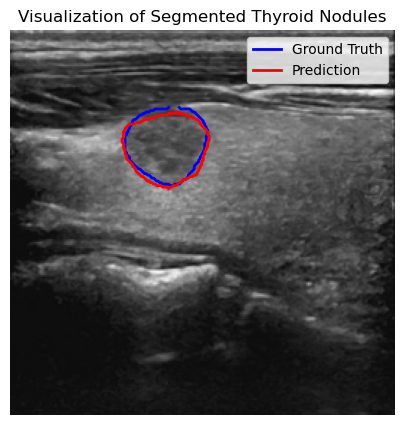

In [108]:
import pandas as pd
RESULT_DIR = "results"
THRESHOLD = 0.5
os.makedirs(RESULT_DIR, exist_ok=True)
# matplotlib.use('Qt5Agg')
cnt = 0
results_dict = {'sample_id':[],'jaccard':[],'f1':[],'recall':[],'precision':[],'accuracy':[]}
for x,y in trainer.test_dataset:
    print(x.shape,y.shape)
    cnt += 1
    out = model(x.to(trainer.device).unsqueeze(0)).squeeze(0)
    out = F.sigmoid(out)
    img,binary_target,binary_pred = plot_sample(x,y,out,cnt,RESULT_DIR,THRESHOLD)
    (jaccard,
    f1,
    recall_score,
    precision_score,accuracy_score) = calculate_metrics(y_true=y,
                                                        y_pred=out,
                                                        threshold=THRESHOLD)
    results_dict['jaccard'].append(jaccard)
    results_dict['f1'].append(f1)
    results_dict['recall'].append(recall_score)
    results_dict['precision'].append(precision_score)
    results_dict['accuracy'].append(accuracy_score)
    results_dict['sample_id'].append(cnt)
    break
# df = pd.DataFrame(results_dict)
# df.to_csv(os.path.join(RESULT_DIR,"results.csv"),index=False)


In [110]:
df.mean()

sample_id    307.500000
jaccard        0.705106
f1             0.794675
recall         0.824987
precision      0.822020
accuracy       0.966108
dtype: float64